<a href="https://colab.research.google.com/github/pbackup12345/xlstm-ts/blob/main/notebooks/sp500_daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Movement Prediction Using Wavelet-Based xLSTM-TS Model

**Notebook 1**: S&P 500 - Daily Close Prices

---


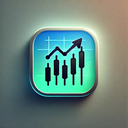

**Note**: Run with T4 GPU in Google Colab! (CUDA is required)

## Constants

**Dataset**: S&P 500 (US)

https://finance.yahoo.com/quote/%5EGSPC/

In [ ]:
# Ticker (check in Yahoo Finance) and custom stock name
TICKER = 'SPY' # S&P 500 index
STOCK = 'S&P 500'

# Date range (YYYY-MM-DD) and frequency
START_DATE = '2000-01-01'
END_DATE = '2024-12-31'
FREQ = '1d' # daily frequency

FILE_NAME = 'sp500_daily' # custom file name

*   **Train**: 01/2000 - 12/2020
*   **Validation**: 01/2021 - 06/2022
*   **Test**: 07/2022 - 12/2023

In [ ]:
# Train, validation, test split
TRAIN_END_DATE = '2022-12-31'
VAL_END_DATE = '2023-12-31'

## Requirements

In [ ]:
repo_url = 'https://github.com/pbackup12345/xlstm-ts.git'

# Clone the repository
!git clone {repo_url}

Cloning into 'xlstm-ts'...
remote: Enumerating objects: 381, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 381 (delta 88), reused 61 (delta 57), pack-reused 252 (from 1)
Receiving objects: 100% (381/381), 17.44 MiB | 21.83 MiB/s, done.
Resolving deltas: 100% (206/206), done.


In [ ]:
%cd xlstm-ts

/content/xlstm-ts


NOTE: It can take a few minutes to install all dependencies.

In [ ]:
!pip install -r requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 77.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 3.6 MB/s eta 0:00:00
Reason for being yanked: The Windows wheels, under some conditions, caused segfaults in unrelated user code.  Due to this we deleted the

In [ ]:
# Add the src directory to the Python path
import sys
import os

# Get the path of the current working directory
current_dir = os.getcwd()

# Construct the path to the 'src' directory in the current folder
src_path = os.path.join(current_dir, 'src')

# Add the 'src' directory to the Python path
if src_path not in sys.path:
    sys.path.append(src_path)

In [ ]:
from ml.utils.imports import *

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Optional: Retrieve MORE hourly data (API limitations apply)

(SKIP THIS STEP IF YOU DO NOT NEED HOURLY DATA MORE THAN 2 YEARS OLD)

**Where to find your Tiingo API Token?**

**Step 1: Create a Tiingo account if you have not already.**

You can do so by visit https://api.tiingo.com and clicking “Sign-up” in the top right corner.

**Step 2: Access the API Token Account Page.**

Visit https://api.tiingo.com/account/api/token to see your API Token and copy it below. Do not share it with anybody as this token will identify your usage with your account.

In [ ]:
os.environ['TIINGO_API_KEY'] = '' # Add your Tiingo API key here

## Dataset

In [ ]:
from ml.data.download import download_data
from ml.utils.visualisation import plot_data

### **Optional: Read local files**

If you want to read the given data from the experiment, UNCOMMENT this code snippet and COMMENT OUT the regular download to proceed.

(NOTE: The regular download will retrieve the exact same data by default, you can experiment with the constants at the top of the file to change it)

In [ ]:
'''
# Read the CSV file and set the "Date" column as the index
file_path = os.path.join('data', 'datasets', FILE_NAME + '.csv')
df = pd.read_csv(file_path, header=0, index_col='Date')
# Convert the index to a datetime object
df.index = df.index.to_series().apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z"))
'''

'\n# Read the CSV file and set the "Date" column as the index\nfile_path = os.path.join(\'data\', \'datasets\', FILE_NAME + \'.csv\')\ndf = pd.read_csv(file_path, header=0, index_col=\'Date\')\n# Convert the index to a datetime object\ndf.index = df.index.to_series().apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z"))\n'

### Download data

- **Tiingo**: If the frequency is hourly and the starting date is more than 2 years before, the Tiingo API will be used. You need to enter the API key to proceed (the steps are explained above). Note that restrictive API limitations apply.

- **Yahoo Finance**: In all other cases, Yahoo Finance will be used. There's no need to enter an API key to download data from it, and there are no API restrictions with responsible usage.

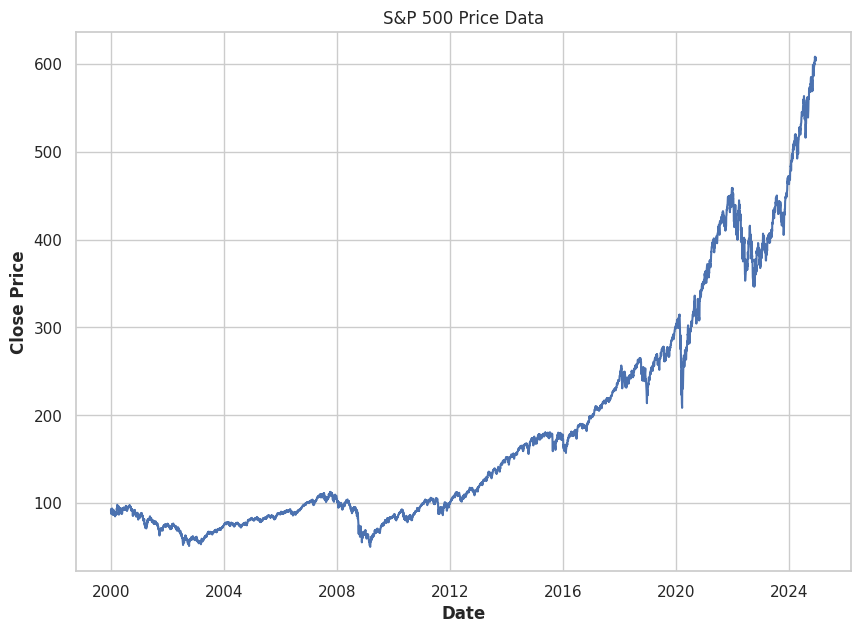

In [ ]:
# Download the data
df = download_data(ticker=TICKER, start_date=START_DATE, end_date=END_DATE, freq=FREQ)

# Plot the raw data
plot_data(df, STOCK)

## Preprocessing

### Wavelet denoising

Reference:
https://doi.org/10.1002/for.3071 (the idea of the wavelet denoising and some parameters are taken from this paper)

In [ ]:
from ml.data.preprocessing import wavelet_denoising, plot_wavelet_denoising

Signal-to-Noise Ratio (SNR): 46.95 dB


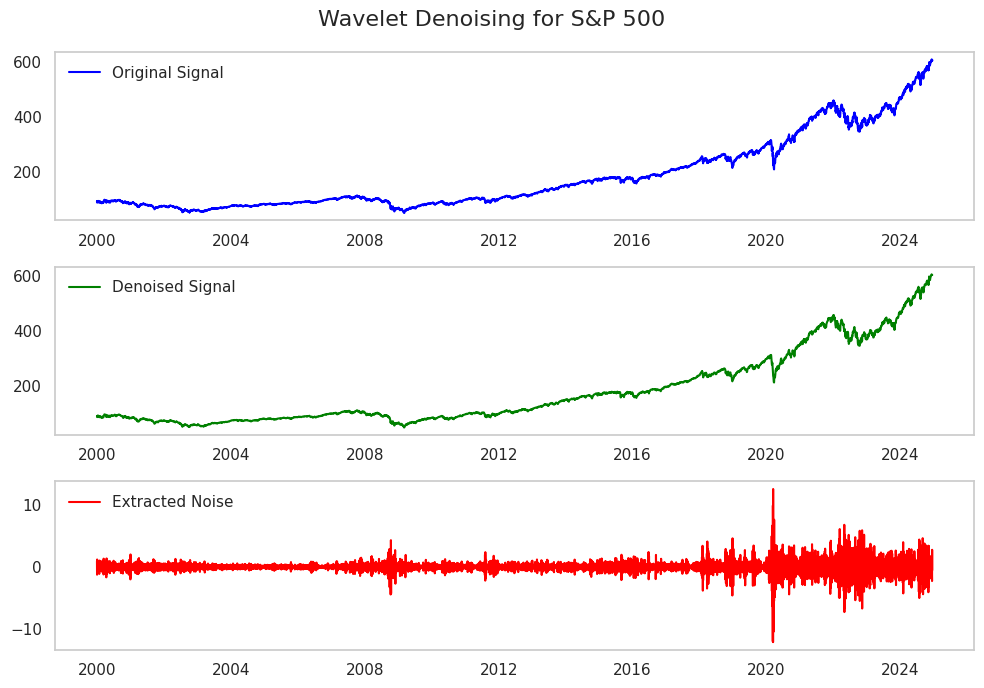

In [ ]:
# Apply denoising

df['Close_denoised'] = wavelet_denoising(df['Close'])

df['Noise'] = df['Close'] - df['Close_denoised']

plot_wavelet_denoising(df, STOCK)

### Process dates

In [ ]:
from ml.data.preprocessing import process_dates

In [ ]:
# Convert the Date column to time zone-naive datetime
df = process_dates(df)

### Model-specific preprocessing

#### For the proposed model

##### Normalise data

In [ ]:
from ml.models.xlstm_ts.preprocessing import normalise_data_xlstm

In [ ]:
close_scaled, scaler = normalise_data_xlstm(df['Close'].values)
close_scaled_denoised, scaler_denoised = normalise_data_xlstm(df['Close_denoised'].values)


##### Create sequences

In [ ]:
from ml.models.xlstm_ts.preprocessing import create_sequences

In [ ]:
X, y, _ = create_sequences(close_scaled, df.index)
X_denoised, y_denoised, dates = create_sequences(close_scaled_denoised, df.index)

##### Train, Validation and Test split

In [ ]:
from ml.models.xlstm_ts.preprocessing import split_train_val_test_xlstm

train X shape: torch.Size([5637, 2, 150, 1])
train y shape: torch.Size([5637, 1])
val X shape: torch.Size([250, 2, 150, 1])
val y shape: torch.Size([250, 1])
test X shape: torch.Size([240, 2, 150, 1])
test y shape: torch.Size([240, 1])


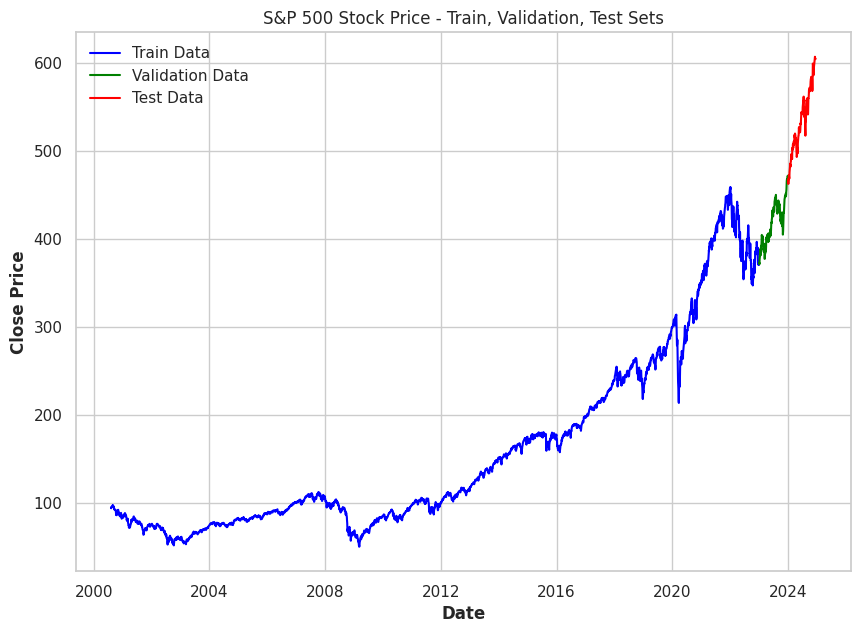

In [ ]:
train_X, train_y, _, val_X, val_y, _, test_X, test_y, _ = split_train_val_test_xlstm(X, y, dates, TRAIN_END_DATE, VAL_END_DATE, scaler, STOCK)

train_X_denoised, train_y_denoised, _, val_X_denoised, val_y_denoised, _, test_X_denoised, test_y_denoised, test_dates = split_train_val_test_xlstm(X_denoised, y_denoised, dates, TRAIN_END_DATE, VAL_END_DATE, scaler_denoised, STOCK)

## Models

In [ ]:
from ml.models.shared.directional_prediction import *
from ml.models.shared.metrics import *
from ml.models.shared.visualisation import *
from ml.models.darts.darts_models import *
from ml.models.darts.training import *

In [ ]:
metrics_accumulator = {}
metrics_accumulator_denoised = {}

### New proposed model: xLSTM-TS, a time series-specific implementation

**References:**

- xLSTM Paper (2024): https://doi.org/10.48550/arXiv.2405.04517

- Official code: https://github.com/NX-AI/xlstm

- Parameters for time series: https://github.com/smvorwerk/xlstm-cuda

#### Configuration

In [ ]:
from ml.models.xlstm_ts.xlstm_ts_model import *
from ml.models.xlstm_ts.logic import *

In [ ]:
plot_architecture_xlstm()

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=2', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_H

Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py310_cu121/slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

#### Training and evaluation

In [ ]:
model_name = 'xLSTM-TS'

**Denoised**

In [ ]:
results_denoised_df, metrics_denoised = run_xlstm_ts(train_X_denoised, train_y_denoised, val_X_denoised, val_y_denoised, test_X_denoised, test_y_denoised, scaler_denoised, STOCK, 'Denoised', test_dates, train_y, val_y, test_y)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4800x1 and 2x64)

In [ ]:
metrics_accumulator_denoised[model_name] = metrics_denoised